# Insurance Claims

This tutorial uses AutoGP to discover time series models of weekly insurance claims data.

In [1]:
import AutoGP
import CSV
import Dates
import DataFrames

using PyPlot: plt

We first load the [`iclaims.csv`](assets/iclaims.csv) dataset from disk.  Since the data is positive we apply a log transform and perform all modeling in this transformed space.

In [2]:
data = CSV.File("assets/iclaims.csv"; header=[:ds, :y], types=Dict(:ds=>Dates.Date, :y=>Float64));
df = DataFrames.DataFrame(data)
df[:,"y"] = log.(df[:,"y"])
show(df)

     │ ds          y
─────┼─────────────────────
   1 │ 2010-01-03  13.3866
   2 │ 2010-01-10  13.6242
   3 │ 2010-01-17  13.3987
   4 │ 2010-01-24  13.1375
   5 │ 2010-01-31  13.1968
   6 │ 2010-02-07  13.147
   7 │ 2010-02-14  13.0859
   8 │ 2010-02-21  13.035
   9 │ 2010-02-28  13.0704
  10 │ 2010-03-07  13.0448
  11 │ 2010-03-14  12.9924
  12 │ 2010-03-21  12.9314
  ⋮  │     ⋮          ⋮
 433 │ 2018-04-15  12.3287
 434 │ 2018-04-22  12.2068
 435 │ 2018-04-29  12.1359
 436 │ 2018-05-06  12.1562
 437 │ 2018-05-13  12.1819
 438 │ 2018-05-20  12.2407
 439 │ 2018-05-27  12.2202
 440 │ 2018-06-03  12.1628
 441 │ 2018-06-10  12.289
 442 │ 2018-06-17  12.2357
 443 │ 2018-06-24  12.3139
           420 rows omitted

Let's hold out the final 100 weeks of observations to serve as test data.

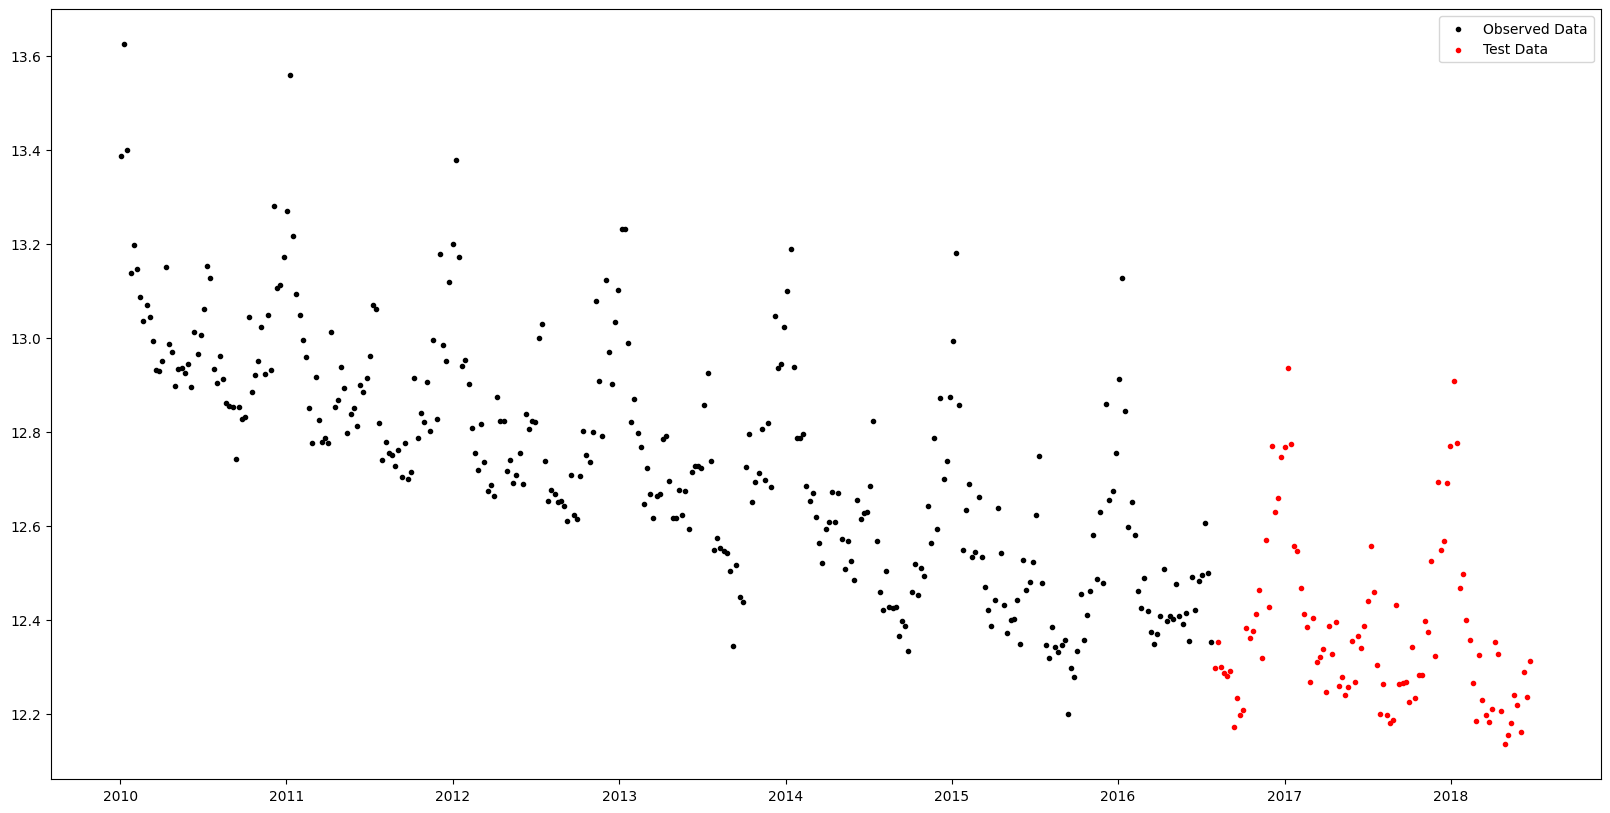

In [3]:
n_test = 100
n_train = DataFrames.nrow(df) - n_test
df_train = df[1:end-n_test, :]
df_test = df[end-n_test+1:end, :]

fig, ax = plt.subplots()
ax.scatter(df_train.ds, df_train.y, marker=".", color="k", label="Observed Data")
ax.scatter(df_test.ds, df_test.y, marker=".", color="r", label="Test Data")
ax.legend()

fig.set_size_inches((20, 10))

The next step is to initialize an [`AutoGP.GPModel`](@ref) instance and fit the model using sequential Monte Carlo structure learning.

In [4]:
model = AutoGP.GPModel(df_train.ds, df_train.y; n_particles=8);

In [5]:
AutoGP.seed!(10)
schedule = AutoGP.Schedule.linear_schedule(n_train, .20)
AutoGP.fit_smc!(model; schedule=schedule, n_mcmc=50, n_hmc=10, shuffle=true, adaptive_resampling=false, verbose=true);

Running SMC round 69/343
Particle Weights: [3.38e-32, 4.11e-20, 7.26e-29, 1.02e-44, 4.74e-57, 9.10e-04, 9.99e-01, 2.71e-17]
Particle ESS: 0.1252276603207894
resampled true
accepted MCMC[4/50] HMC[40/40]
accepted MCMC[6/50] HMC[48/50]
accepted MCMC[8/50] HMC[62/64]
accepted MCMC[7/50] HMC[61/63]
accepted MCMC[7/50] HMC[68/69]
accepted MCMC[9/50] HMC[73/77]
accepted MCMC[12/50] HMC[92/97]
accepted MCMC[14/50] HMC[114/118]
Running SMC round 138/343
Particle Weights: [1.10e-01, 1.39e-01, 1.98e-01, 1.71e-01, 1.66e-01, 1.78e-01, 1.80e-02, 2.08e-02]
Particle ESS: 0.7836676673226702
resampled true
accepted MCMC[2/50] HMC[3/5]
accepted MCMC[3/50] HMC[15/17]
accepted MCMC[13/50] HMC[0/13]
accepted MCMC[15/50] HMC[0/15]
accepted MCMC[8/50] HMC[17/24]
accepted MCMC[8/50] HMC[12/20]
accepted MCMC[12/50] HMC[20/32]
accepted MCMC[16/50] HMC[62/73]
Running SMC round 207/343
Particle Weights: [1.21e-18, 1.72e-18, 1.00e+00, 3.00e-20, 1.48e-12, 2.59e-17, 8.86e-18, 1.49e-17]
Particle ESS: 0.12500000000036

Plotting the forecasts from each particle reflects the structural uncertainty.  7/8 particles have inferred a periodic component ([`AutoGP.GP.Periodic`](@ref)) with additive linear trend [`AutoGP.GP.Linear`](@ref). 1/8 of the particles has inferred a sum of a periodic kernel and gamma exponential ([`AutoGP.GP.GammaExponential`](@ref)) kernel, which is stationary but not "smooth" (formally, not mean-square differentiable).

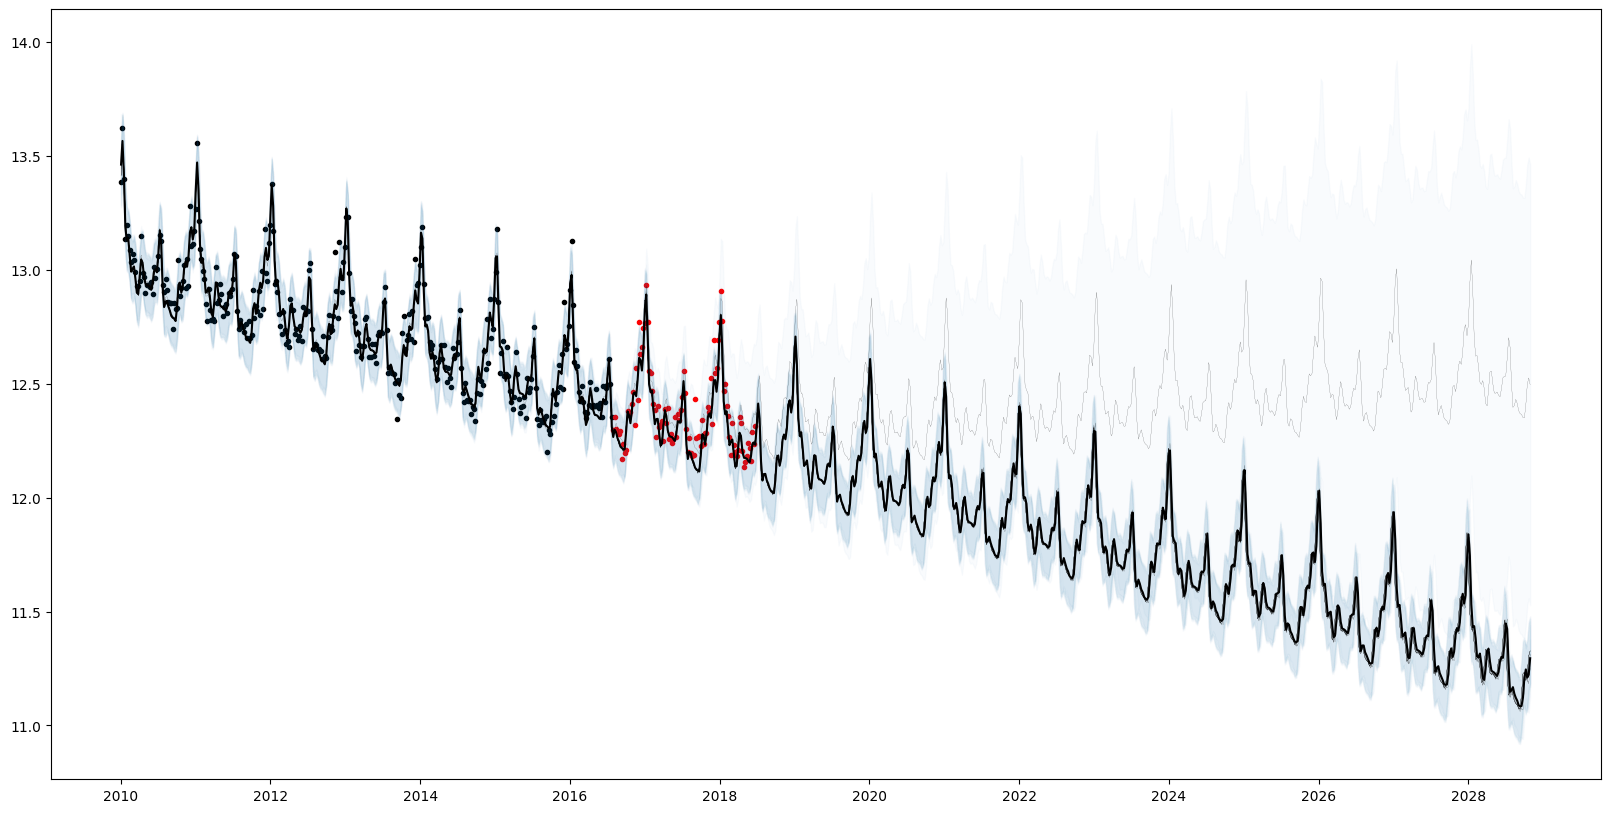

In [6]:
# Generate in-sample and future predictions.
ds_future = range(start=df_test.ds[end]+Dates.Week(1), step=Dates.Week(1), length=54*10)
ds_query = vcat(df_train.ds, df_test.ds, ds_future)
forecasts = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975]);
weights = AutoGP.particle_weights(model)

# Plot the data.
fig, ax = plt.subplots()
ax.scatter(df_train.ds, df_train.y, marker=".", color="k", label="Observed Data")
ax.scatter(df_test.ds, df_test.y, marker=".", color="r", label="Test Data")

# Plot the forecasts from each particle.
for i=1:AutoGP.num_particles(model)
    subdf = forecasts[forecasts.particle.==i,:]
    ax.plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.1)
    ax.fill_between(
        subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"];
        color="tab:blue", alpha=0.025)
end

# Plot the grand mean.
mvn = AutoGP.predict_mvn(model, ds_query)
ax.plot(ds_query, AutoGP.Distributions.mean(mvn), color="k");

fig.set_size_inches((20, 10))

In [7]:
for (w, k) in zip(AutoGP.particle_weights(model), AutoGP.covariance_kernels(model))
    println("Particle weight $(w)")
    display(k)
end

Particle weight 0.004250523793201452


＋
├── LIN(0.43; 0.06, 0.40)
└── PER(0.27, 0.15; 0.12)


Particle weight 0.00038679558572478394


＋
├── LIN(0.21; 0.48, 0.28)
└── PER(0.31, 0.15; 0.14)


Particle weight 0.0053919770385277765


＋
├── PER(0.27, 0.15; 0.12)
└── LIN(0.10; 0.11, 1.58)


Particle weight 0.005373167226484039


＋
├── LIN(0.55; 0.04, 0.06)
└── PER(0.27, 0.15; 0.12)


Particle weight 0.00021615764118894197


＋
├── LIN(0.45; 0.05, 0.18)
└── PER(0.27, 0.15; 0.12)


Particle weight 0.5354267607554092


＋
├── PER(0.27, 0.15; 0.12)
└── LIN(0.22; 0.19, 0.18)


Particle weight 0.43964210411447696


＋
├── LIN(0.09; 0.12, 0.11)
└── PER(0.23, 0.15; 0.11)


Particle weight 0.00931251384499995


＋
├── GE(1.72, 1.66; 0.13)
└── PER(0.29, 0.15; 0.12)


We can also query the overall quantiles of the predictive distribution over new data by using [`AutoGP.predict_quantile`](@ref).

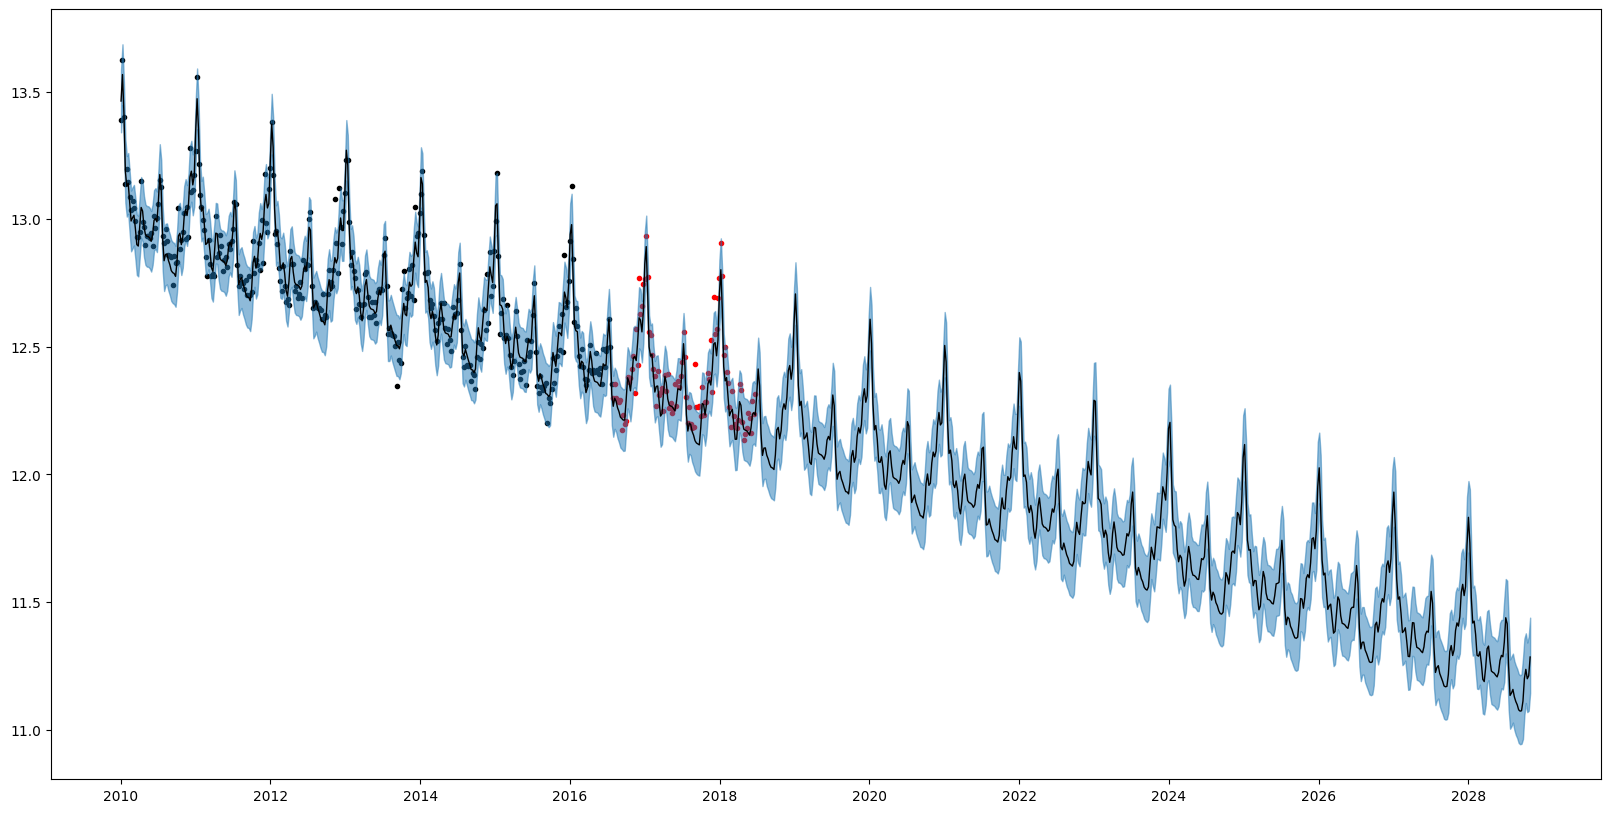

In [8]:
# Obtain overall quantiles.
quantiles_lo, = AutoGP.predict_quantile.(Ref(model), Ref(ds_query), .025, tol=1e-6)
quantiles_md, = AutoGP.predict_quantile.(Ref(model), Ref(ds_query), .50, tol=1e-6)
quantiles_hi, = AutoGP.predict_quantile.(Ref(model), Ref(ds_query), .975, tol=1e-6)

# Plot the combined predictions.
fig, ax = plt.subplots()
ax.scatter(df_train.ds, df_train.y, marker=".", color="k", label="Observed Data")
ax.scatter(df_test.ds, df_test.y, marker=".", color="r", label="Test Data")
ax.plot(ds_query, quantiles_md, color="k", linewidth=1)
ax.fill_between(ds_query, quantiles_lo, quantiles_hi, color="tab:blue", alpha=.5)
fig.set_size_inches((20, 10))

!!! note

    Mean forecasts, quantile forecasts, and probability densities values obtained via [`AutoGP.predict`](@ref) and [`AutoGP.predict_proba`](@ref) are all in the transformed (log space).  Only quantile forecasts can be transformed back to direct space via `exp`.  Converting mean forecasts and probability densities can be performed by using the [`Distributions.MvLogNormal`](https://juliastats.org/Distributions.jl/stable/multivariate/#Distributions.MvLogNormal) constructor, as demonstrated below.

In [9]:
import Distributions
log_mvn_components = [Distributions.MvLogNormal(d) for d in Distributions.components(mvn)]
log_mvn_weights = Distributions.probs(mvn)
log_mvn = Distributions.MixtureModel(log_mvn_components, log_mvn_weights);

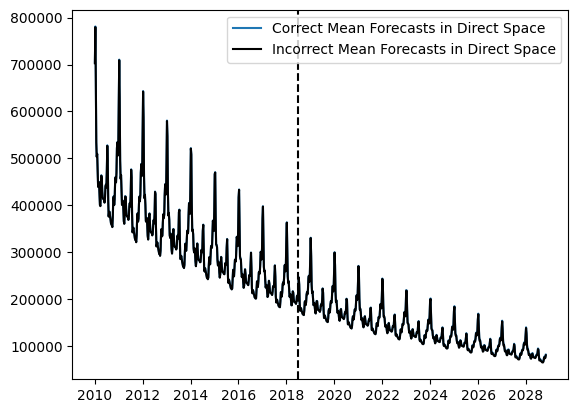

PyObject <matplotlib.legend.Legend object at 0x7f5b068d02e0>

In [10]:
fig, ax = plt.subplots()
ax.plot(ds_query, Distributions.mean(log_mvn), color="tab:blue", label="Correct Mean Forecasts in Direct Space")
ax.plot(ds_query, exp.(Distributions.mean(mvn)), color="k", label="Incorrect Mean Forecasts in Direct Space")
ax.axvline(df_test.ds[end], color="k", linestyle="--")
ax.legend()

The difference between the blue and black curves is too small to observe on the scale above; let us plot the bias that arises from doing a naive transformation of the predictive mean.

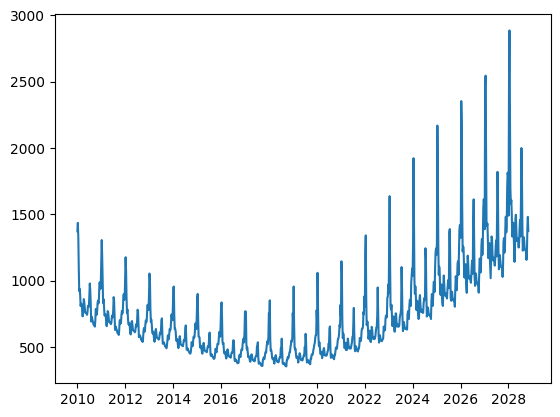

In [11]:
fig, ax = plt.subplots()
ax.plot(ds_query, Distributions.mean(log_mvn) - exp.(Distributions.mean(mvn)));